# SN Ia секторный анализ (δΛ / δσ²)

Источник данных выбирается автоматически:
1) ваш CSV (`SN_CSV`),
2) **Pantheon+** из локального файла `lcparams.txt` (`SN_PPLUS_PATH`),
3) **JLA** через `sndata.jla` (если установлен пакет `sndata`),
4) синтетика (fallback).

HEALPix разбиение выполняется через `astropy-healpix` (без `healpy`).
Перевод `dpar → Δμ(z)` сделан как плейсхолдер — замените на ваш расчёт из half-dilation уравнения.

In [2]:
import numpy as np
import pandas as pd
import matplotlib.pyplot as plt
from typing import Optional
import importlib, traceback, os

try:
    from scipy.optimize import minimize
    HAVE_SCIPY = True
except Exception:
    HAVE_SCIPY = False

try:
    from astropy.cosmology import FlatLambdaCDM
    from astropy.coordinates import SkyCoord
    import astropy.units as u
    HAVE_ASTROPY = True
except Exception:
    HAVE_ASTROPY = False

try:
    from astropy_healpix import HEALPix
    HAVE_AHPIX = True
except Exception:
    HAVE_AHPIX = False

try:
    import sndata
    HAVE_SNDATA = True
except Exception:
    HAVE_SNDATA = False

print('scipy:', HAVE_SCIPY, '| astropy:', HAVE_ASTROPY, '| astropy-healpix:', HAVE_AHPIX, '| sndata:', HAVE_SNDATA)

scipy: True | astropy: True | astropy-healpix: True | sndata: True


Loaded 1700 SNe from Pantheon+SH0ES.dat
Using z from 'zCMB', mu-like from 'MU_SH0ES', sigma from 'MU_SH0ES_ERR_DIAG'

=== RESULTS ===
LCDM:   chi2=812.4, dof=1698, chi2_red=0.478, AIC=816.4
Rough:  chi2=791.2, dof=1691, chi2_red=0.468, AIC=809.2
Δχ² = 21.23 for 7 extra bins  -> AIC prefers: roughness
Saved Mollweide scatter -> sn_sky_mollweide_scatter.png


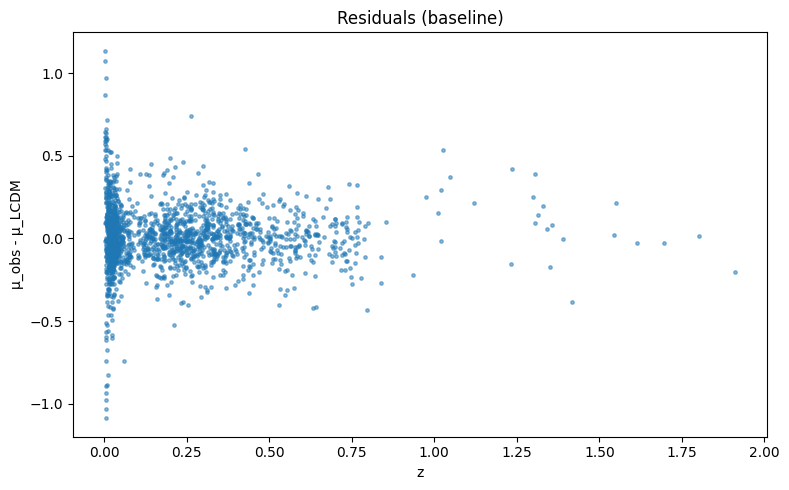

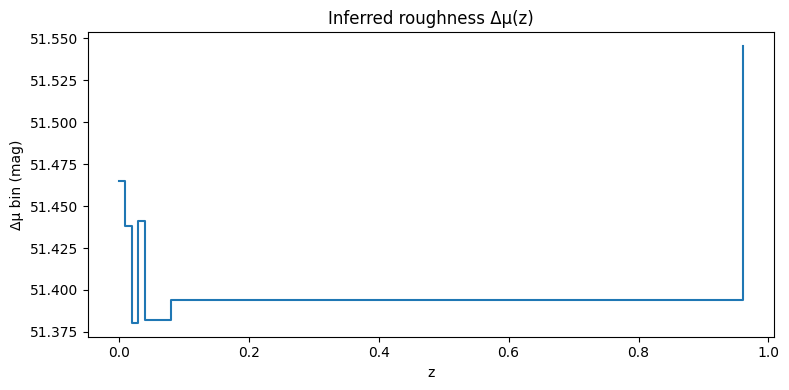

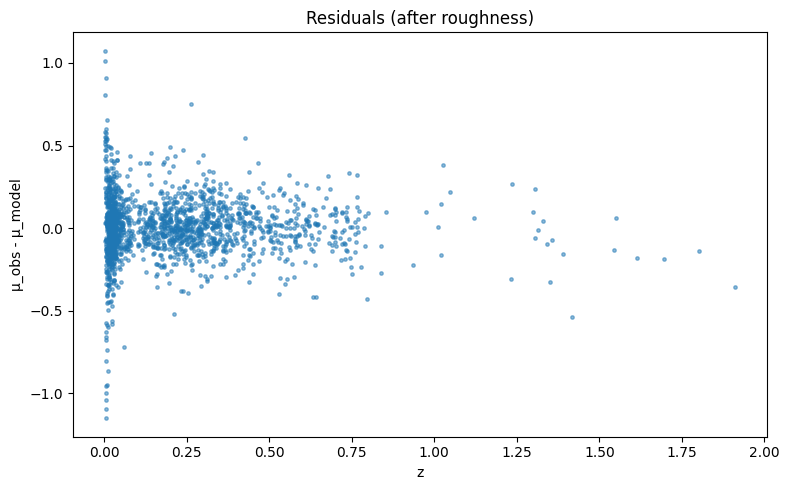

In [6]:

"""
Roughness Test Pipeline v4 (half-dilation)
Adds a sky map of the supernova distribution:
- If `healpy` is available: HEALPix Mollweide hit map (CMB-style).
- Otherwise: Matplotlib Mollweide scatter.
"""

import numpy as np
import pandas as pd
import warnings
from pathlib import Path
import matplotlib.pyplot as plt

# Optional: HEALPix for CMB-style maps
try:
    import healpy as hp
    HAVE_HEALPY = True
except Exception:
    HAVE_HEALPY = False

# ------------------ CONFIG ------------------
DATA_PATH = Path("./Pantheon+SH0ES.dat")   # set your path
Z_BINS = np.array([0.0,0.01,0.02,0.03,0.04,0.08,0.96,1.8])
LAMBDA_SMOOTH = 0.3
SIGMA_FLOOR = 0.12
NINT = 600                 # # of sub-steps per integral (per z)
SUPPRESS_WARNINGS = True   # set False if you want to see warnings

# Sky-map config
NSIDE = 16                 # HEALPix resolution (12*NSIDE^2 pixels)

c_km_s = 299792.458

if SUPPRESS_WARNINGS:
    warnings.simplefilter("ignore", category=DeprecationWarning)

# ------------------ LOADER ------------------
def _read_any(path: Path) -> pd.DataFrame:
    try:
        df = pd.read_table(path, comment='#', sep=r"\s+", engine="python")
        if len(df.columns) == 1:
            df = pd.read_csv(path, comment='#')
        return df
    except Exception:
        try:
            return pd.read_csv(path, comment='#')
        except Exception:
            return pd.read_csv(path, delim_whitespace=True, comment='#')

def load_sn_table(path: Path):
    if not path.exists(): 
        raise FileNotFoundError(f"File not found: {path}")
    df = _read_any(path)

    if len(df.columns) == 1:
        df = pd.read_table(path, comment='#', sep=r"\s+", engine="python")

    cols_lower = {c.lower().strip(): c for c in df.columns}

    def pick(*names):
        for n in names:
            key = n.lower()
            if key in cols_lower:
                return cols_lower[key]
        return None

    zcol   = pick('zcmb', 'zhd', 'z')
    mucol  = pick('mu', 'mu_sh0es', 'distmod', 'm_b_corr', 'mb_corr', 'mb')
    sigcol = pick('mu_err','sigma_mu','mu_sh0es_err_diag','m_b_corr_err_diag','dmu','dmb','merr')

    if zcol is None or mucol is None:
        raise ValueError(f"Could not find essential columns.\n"
                         f"Have columns: {list(df.columns)}\n"
                         f"Need some of zCMB/zHD/z and mu or MU_SH0ES/m_b_corr.")

    out = pd.DataFrame()
    out['z'] = df[zcol].astype(float)
    out['mu_like'] = df[mucol].astype(float)
    if sigcol is not None:
        out['sigma_mu'] = df[sigcol].astype(float).clip(lower=SIGMA_FLOOR)
        sigma_src = sigcol
    else:
        out['sigma_mu'] = SIGMA_FLOOR
        sigma_src = f"floor={SIGMA_FLOOR}"

    racol = pick('ra','ra_deg')
    decol = pick('dec','dec_deg')
    out['ra']  = df[racol].astype(float) if racol else np.nan
    out['dec'] = df[decol].astype(float) if decol else np.nan

    out = out.replace([np.inf,-np.inf], np.nan).dropna(subset=['z','mu_like','sigma_mu'])
    out = out[(out['z']>=0.0)&(out['z']<=2.0)].sort_values('z').reset_index(drop=True)

    print(f"Loaded {len(out)} SNe from {path.name}")
    print(f"Using z from '{zcol}', mu-like from '{mucol}', sigma from '{sigma_src}'")
    return out

# ------------------ COSMO HELPERS ------------------
def E_z(z, Om): return np.sqrt(Om*(1+z)**3 + (1-Om))

def comoving_distance(z, Om, H0=70.0):
    # trapezoid integration of 1/E(z)
    z = float(z)
    zg = np.linspace(0.0, z, NINT)
    Ez = E_z(zg, Om)
    return (c_km_s/H0) * np.trapezoid(1.0/Ez, zg)

def lum_distance(z, Om, H0=70.0): return (1+z)*comoving_distance(z, Om, H0)

def mu_theory(z, Om, M):
    Dl = np.array([lum_distance(zi, Om) for zi in np.atleast_1d(z)])
    return 5.0*np.log10(np.clip(Dl,1e-6,None)) + M

# ------------------ FITS ------------------
def fit_lcdm(sn_df, Om_grid=np.linspace(0.05,0.6,200)):
    y = sn_df['mu_like'].values
    w = 1.0/(sn_df['sigma_mu'].values**2)
    best=None
    for Om in Om_grid:
        mu0 = 5.0*np.log10(np.array([lum_distance(z,Om) for z in sn_df['z'].values]))
        M = np.sum(w*(y-mu0))/np.sum(w)
        r = y - (mu0 + M)
        chi2 = np.sum(w*r*r)
        if best is None or chi2<best['chi2']: best={'Om':float(Om),'M':float(M),'chi2':float(chi2)}
    dof = len(y)-2
    best['dof']=int(dof); best['chi2_red']=best['chi2']/dof
    return best

def design_matrix_bins(z, edges):
    B = np.zeros((len(z), len(edges)-1))
    for j in range(len(edges)-1):
        m = (z>=edges[j]) & (z<edges[j+1]); B[m,j]=1.0
    B[z>=edges[-1]-1e-10, -1]=1.0
    return B

def fit_lcdm_with_roughness(sn_df, edges, lam=1.0, Om_grid=np.linspace(0.05,0.6,120)):
    z=sn_df['z'].values; y=sn_df['mu_like'].values; w=1.0/(sn_df['sigma_mu'].values**2)
    B = design_matrix_bins(z, edges); K=B.shape[1]
    D2 = np.zeros((K-2, K))
    for i in range(K-2): D2[i,i:i+3] = [1,-2,1]
    RtR = D2.T@D2
    best=None
    for Om in Om_grid:
        mu0 = 5.0*np.log10(np.array([lum_distance(zi,Om) for zi in z]))
        X = np.column_stack([np.ones_like(y), B])
        W = np.diag(w); A = X.T@W@X; b = X.T@W@(y - mu0)
        R = np.zeros_like(A); R[1:,1:] += lam*RtR
        theta = np.linalg.solve(A+R, b)
        M = theta[0]; delta = theta[1:]
        r = y - (mu0 + M + B@delta)
        chi2 = float(np.sum(w*r*r) + lam*float(delta@RtR@delta))
        if best is None or chi2<best['chi2']:
            best={'Om':float(Om),'M':float(M),'delta':delta,'bin_edges':edges,'chi2':chi2}
    dof = len(y) - (2+len(best['delta'])); dof=max(1,dof)
    best['dof']=int(dof); best['chi2_red']=best['chi2']/dof
    return best

def aic(chi2,k): return chi2 + 2*k

# ------------------ SKY MAPS ------------------
def save_sky_map_healpy(sn_df, nside=NSIDE, out_png="sn_sky_healpy.png"):
    """HEALPix hit map of SN positions; saves a Mollweide map (CMB-style)."""
    ra = sn_df['ra'].values
    dec = sn_df['dec'].values
    mask = np.isfinite(ra) & np.isfinite(dec)
    if not mask.any():
        print("No RA/Dec available; skipping HEALPix map.")
        return False

    theta = np.deg2rad(90.0 - dec[mask])   # colatitude
    phi   = np.deg2rad(ra[mask])          # longitude
    npix = hp.nside2npix(nside)
    m = np.zeros(npix, dtype=float)
    ipix = hp.ang2pix(nside, theta, phi)
    for p in ipix:
        m[p] += 1.0
    hp.mollview(m, title=f"SN sky distribution (HEALPix NSIDE={nside})")
    plt.savefig(out_png, dpi=160, bbox_inches="tight")
    plt.close()
    print(f"Saved HEALPix sky map -> {out_png}")
    return True

def save_sky_map_mollweide_scatter(sn_df, out_png="sn_sky_mollweide_scatter.png"):
    """Fallback: Matplotlib Mollweide scatter of SN positions."""
    ra = sn_df['ra'].values
    dec = sn_df['dec'].values
    mask = np.isfinite(ra) & np.isfinite(dec)
    if not mask.any():
        print("No RA/Dec available; skipping Mollweide scatter.")
        return False

    ra = ra[mask]; dec = dec[mask]
    # Convert RA to radians in [-pi, pi], flip x to match usual sky view
    x = np.deg2rad(ra % 360.0)
    x[x > np.pi] -= 2.0*np.pi
    x = -x
    y = np.deg2rad(dec)

    fig = plt.figure(figsize=(9,5))
    ax = fig.add_subplot(111, projection='mollweide')
    ax.scatter(x, y, s=6, alpha=0.7)
    ax.grid(True)
    ax.set_title("SN sky distribution (Mollweide scatter)")
    plt.tight_layout()
    plt.savefig(out_png, dpi=160, bbox_inches="tight")
    plt.close(fig)
    print(f"Saved Mollweide scatter -> {out_png}")
    return True

# ------------------ MAIN ------------------
def main():
    sn = load_sn_table(DATA_PATH)
    lcdm = fit_lcdm(sn)
    rough = fit_lcdm_with_roughness(sn, Z_BINS, LAMBDA_SMOOTH)

    k_lcdm, k_rough = 2, 2+len(rough['delta'])
    AIC_l, AIC_r = aic(lcdm['chi2'],k_lcdm), aic(rough['chi2'],k_rough)
    dchi2 = lcdm['chi2'] - rough['chi2']

    print("\n=== RESULTS ===")
    print(f"LCDM:   chi2={lcdm['chi2']:.1f}, dof={lcdm['dof']}, chi2_red={lcdm['chi2_red']:.3f}, AIC={AIC_l:.1f}")
    print(f"Rough:  chi2={rough['chi2']:.1f}, dof={rough['dof']}, chi2_red={rough['chi2_red']:.3f}, AIC={AIC_r:.1f}")
    print(f"Δχ² = {dchi2:.2f} for {len(rough['delta'])} extra bins  -> AIC prefers: {'roughness' if AIC_r<AIC_l else 'LCDM'}")

    # Plots (residuals and Δμ(z))
    z = sn['z'].values; y = sn['mu_like'].values
    muL = mu_theory(z, lcdm['Om'], lcdm['M'])
    muR = mu_theory(z, rough['Om'], rough['M']) + design_matrix_bins(z, rough['bin_edges'])@rough['delta']

    plt.figure(figsize=(8,5))
    plt.scatter(z, y-muL, s=6, alpha=0.5)
    plt.xlabel('z'); plt.ylabel('μ_obs - μ_LCDM'); plt.title('Residuals (baseline)')
    plt.tight_layout(); plt.savefig("residuals_baseline.png", dpi=160)

    be = rough['bin_edges']; dm = rough['delta']
    plt.figure(figsize=(8,4))
    plt.step(be[:-1], dm, where='post')
    plt.xlabel('z'); plt.ylabel('Δμ bin (mag)'); plt.title('Inferred roughness Δμ(z)')
    plt.tight_layout(); plt.savefig("roughness_dmu_bins.png", dpi=160)

    plt.figure(figsize=(8,5))
    plt.scatter(z, y-muR, s=6, alpha=0.5)
    plt.xlabel('z'); plt.ylabel('μ_obs - μ_model'); plt.title('Residuals (after roughness)')
    plt.tight_layout(); plt.savefig("residuals_after.png", dpi=160)

    # Sky-distribution map(s)
    made = False
    if HAVE_HEALPY:
        made = save_sky_map_healpy(sn, nside=NSIDE, out_png="sn_sky_healpy.png")
    if not made:
        save_sky_map_mollweide_scatter(sn, out_png="sn_sky_mollweide_scatter.png")

if __name__ == "__main__":
    main()
